PyTorch model to segment leaf images. Created by running a convolutional layer over raw images from Plant Village dataset with the segmented images as the labels. MSE loss is used.

In [ ]:
!git clone https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.git

Cloning into 'plantvillage_deeplearning_paper_dataset'...
remote: Enumerating objects: 163224, done.
remote: Total 163224 (delta 0), reused 0 (delta 0), pack-reused 163224
Receiving objects: 100% (163224/163224), 2.00 GiB | 37.24 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Checking out files: 100% (182401/182401), done.


In [ ]:
import os
import torch
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from PIL import Image
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import random

directory = '/content/plantvillage_deeplearning_paper_dataset/raw/'
raw_dir = []
raw_names = []
seg_dir = []
seg_names = []
dir = directory + 'color/'
for direct in os.listdir(dir):
    #print(direct)
    direct = dir + direct + '/'
    for file in os.listdir(direct):
      #print(file)
      raw_names.append(file[:-4])
      raw_dir.append(direct + file)
dir = directory + 'segmented/'
for direct in os.listdir(dir):
    #print(direct)
    direct = dir + direct + '/'
    for file in os.listdir(direct):
      #print(file)
      if file != '7e1fd9b9-1fd9-4f98-93f5-8cf9ebc60dd9___FAM_B.Msls 4430_final_masked.jpg':
        seg_names.append(file[:-17])
        seg_dir.append(direct + file)
print(len(raw_dir))
print(len(seg_dir))

54305
54305


In [ ]:
torch.manual_seed(0)
random.seed(0)

In [ ]:
raw = []
seg = []
for i in range(len(raw_names)):
    for j in range(len(seg_names)):
      if raw_names[i] in seg_names[j] or seg_names[j] in raw_names[i]:
        raw.append(raw_dir[i])
        seg.append(seg_dir[j])
        found = True
        break
    if(not found):
      print(raw_names[i])

In [ ]:
mismatch = []
for i in range(len(raw)):
  if transforms.ToTensor()(Image.open(raw[i])).shape != transforms.ToTensor()(Image.open(seg[i])).shape:
    mismatch.append(i)
#print(sum([transforms.ToTensor()(Image.open(raw[i])).shape != transforms.ToTensor()(Image.open(seg[i])).shape for i in range(54305)]))

In [ ]:
print(mismatch)
mismatch.reverse()
print(mismatch)
for i in mismatch:
  raw.remove(raw[i])
  seg.remove(seg[i])

[1317, 8158, 11551, 11799, 35967, 39167]
[39167, 35967, 11799, 11551, 8158, 1317]


In [ ]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        raw = torch.Tensor.float(transform(transforms.ToTensor()(Image.open(self.data[idx][0]))[:3]))
        seg = torch.Tensor.float(transform(transforms.ToTensor()(Image.open(self.data[idx][1]))[:3]))
        #raw = torch.Tensor.float(transforms.ToTensor()(Image.open(self.data[idx][0]))[:3])
        #seg = torch.Tensor.float(transforms.ToTensor()(Image.open(self.data[idx][1]))[:3])
        return raw, seg

In [ ]:
def split(raw, seg, r = 0.8):
  k = int(r*len(seg))
  train_idx = random.sample(list(range(len(seg))), k = k)
  print(k)
  print(len(raw))
  test_idx = [i for i in range(len(seg)) if i not in train_idx]
  train_data = [[raw[i], seg[i]] for i in train_idx]
  test_data = [[raw[i], seg[i]] for i in test_idx]
  return train_data, test_data


In [ ]:
train, test = split(raw, seg)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# test_transform = transforms.Compose([transforms.Resize((16)),
#      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
train_set = CustomImageDataset(train, transform)
test_set = CustomImageDataset(test, transform)

43439
54299


In [ ]:
import numpy as np
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 68, 266)


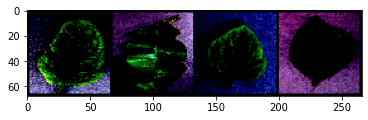

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 68, 266)


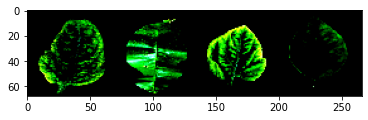

In [ ]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(images[0])
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, padding = 1)
        # #self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 2)
        # self.conv3 = nn.Conv2d(16, 6, 3)
        # self.conv4 = nn.Conv2d(6, 3, 3)
        

    def forward(self, x):
        #print(x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # #print(x.shape)
        # x = self.pool(F.relu(self.conv2(x)))
        # #print(x.shape)
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # #print(x.shape)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
losses = []
device = 'cuda'
net = net.to(device)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5000:.3f}')
            running_loss = 0.0
    losses.append(running_loss)
    PATH = f'base_color_transform_nocorn_epoch:{epoch}.pth'
    torch.save(net.state_dict(), PATH)

print('Finished Training')

[1,  2000] loss: 0.485
[1,  7000] loss: 0.509
[2,  2000] loss: 0.157
[2,  7000] loss: 0.384
[3,  2000] loss: 0.154
[3,  7000] loss: 0.381
[4,  2000] loss: 0.152
[4,  7000] loss: 0.378
[5,  2000] loss: 0.154
[5,  7000] loss: 0.379
[6,  2000] loss: 0.152
[6,  7000] loss: 0.378
[7,  2000] loss: 0.151
[7,  7000] loss: 0.378
[8,  2000] loss: 0.153
[8,  7000] loss: 0.376
[9,  2000] loss: 0.149
[9,  7000] loss: 0.374
[10,  2000] loss: 0.148
[10,  7000] loss: 0.377
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 68, 266)


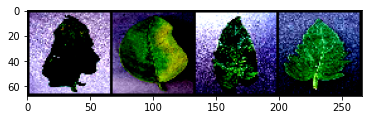

(3, 68, 266)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


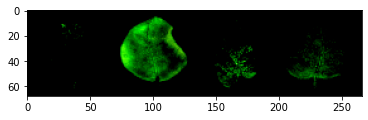

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 68, 266)


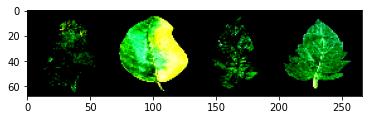

In [ ]:
dataiter = iter(testloader)
raws, segs = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(raws))
raws = raws.to(device)
imshow(torchvision.utils.make_grid(net(raws).cpu()))
imshow(torchvision.utils.make_grid(segs))
#imshow(images[0])
#print(images[0]).shape